In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

In [23]:
df_matched_event = pd.read_csv('../data/matched_events_from_SA_20160201_20201006.csv')
myshake_network_detection = pd.read_pickle('../data/myshake_detection_results.pkl')
df_event = pd.read_hdf('../data/event_20160201_20190929.h5')
df_event_select = df_event[(df_event['system']=='dm') & (df_event['type']=='new')]

In [93]:
def get_shakealert_first_alert(evid, df_matched_event, df_event_select):
    df_matched_event_select = df_matched_event[df_matched_event['catalogid'] == evid]
    evtime = df_matched_event_select['time.1'].iloc[0]
    evla = df_matched_event_select.iloc[0]['lat']
    evlo = df_matched_event_select.iloc[0]['lon']
    df_matched_event_select = df_matched_event_select.sort_values('time')
    
    first_alert_time, dmag, dsecs, dkm = 9999, 9999, 9999, 9999
    for ix, row in df_matched_event_select.iterrows():
        event_id = row['id']

        df_alert = df_event_select[df_event_select['id'] == event_id]
        min_alert_time = 9999
        if len(df_alert) > 0:
            alert_time_s = (df_alert['alert_time'] - evtime).values[0]
            # Make sure the alert time is larger than origin time
            if (alert_time_s < min_alert_time) & (alert_time_s > 0):
                alert_info = df_alert
                first_alert_time = alert_time_s
                dmag = row['dmag']
                dsecs = row['dsecs']
                dkm = row['dkm']
                min_alert_time = alert_time_s
                
    return first_alert_time, dmag, dsecs, dkm

In [94]:
first_alert_detection_compare = {}
for evid, value in myshake_network_detection.items():
    
    detection = value[0][0][0][0]
    first_alert_detection_compare[evid] = {}
    
    if evid in df_matched_event.catalogid.to_list():
        first_alert_time, dmag, dsecs, dkm = get_shakealert_first_alert(evid, df_matched_event, df_event_select)
        first_alert_detection_compare[evid]['shakealert'] = [1, first_alert_time, dmag, dsecs, dkm]
    else:
        first_alert_detection_compare[evid]['shakealert'] = [0, np.nan, np.nan, np.nan, np.nan]
    
    if len(detection) == 0:
        myshake_detection_time = np.nan
        first_alert_detection_compare[evid]['myshake'] = [0, np.nan, np.nan, np.nan, np.nan]
        continue
    
    dmag, dkm, dsecs, first_alert_time, total_opt_fails, npwave, nswave, first_centroid_error = value[0][1]
    first_alert_detection_compare[evid]['myshake'] = [1, first_alert_time, dmag, dsecs, dkm]

## How many events each system detected

In [ ]:
n_shakealert = 0
n_myshake = 0
n_both = 0
alert_time_diff_s_myshake_shakealert = []
for key, detections in first_alert_detection_compare.items():
    myshake_detection = detections['myshake']
    shakealert_detection = detections['shakealert']
    
    if myshake_detection[0]:
        n_myshake += 1
    
    if shakealert_detection[0]:
        n_shakealert += 1
        if shakealert_detection[1] ==9999:
            print('Here')
        
    if (myshake_detection[0]) & (shakealert_detection[0]):
        n_both += 1
        alert_time_diff_s_myshake_shakealert.append(myshake_detection[1] - shakealert_detection[1])
        
    if (myshake_detection[0]) & (shakealert_detection[0]==0):
        print(evid)

In [75]:
print(f'Out of {len(first_alert_detection_compare)} events:\n'
      f'    MyShake detected: {n_myshake}\n'
      f'    ShakeAlert detected: {n_shakealert}\n'
      f'    {n_both} events detected by both system.')

Out of 785 events:
    MyShake detected: 107
    ShakeAlert detected: 600
    104 events detected by both system.


In [80]:
df_matched_event

,Unnamed: 0,id,ver,catid,time,day,dsecs,dkm,dmag,modtime,id.1,catalogid,lat,lon,depth,mag,time.1,day.1,modtime.1
0,174016,2271,0,243766,1.454301e+09,20160201,0.427,4.02229,-0.1888,1475002296,243766,ci37301639,33.056500,-116.414667,14.62,2.30,1.454301e+09,20160201,1473722951
1,174017,2273,0,243766,1.454301e+09,20160201,0.427,4.02229,-0.1888,1475002296,243766,ci37301639,33.056500,-116.414667,14.62,2.30,1.454301e+09,20160201,1473722951
2,174018,2272,0,243766,1.454301e+09,20160201,0.427,4.02229,-0.1888,1475002296,243766,ci37301639,33.056500,-116.414667,14.62,2.30,1.454301e+09,20160201,1473722951
3,174015,2274,0,243766,1.454301e+09,20160201,0.427,4.02229,-0.1888,1475002296,243766,ci37301639,33.056500,-116.414667,14.62,2.30,1.454301e+09,20160201,1473722951
4,149648,2277,0,243770,1.454317e+09,20160201,-0.091,1.43670,0.1319,1475002296,243770,ci37301671,33.342333,-116.389333,8.68,1.87,1.454317e+09,20160201,1473722951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195171,144486,222176,0,58612117,1.602012e+09,20201006,-31.795,1.81970,0.3955,1602012155,58612117,ci39654600,33.038500,-115.584500,4.99,2.09,1.602012e+09,20201006,1602012243
195172,144487,222180,0,58612117,1.602012e+09,20201006,-31.795,1.81970,0.3955,1602012155,58612117,ci39654600,33.038500,-115.584500,4.99,2.09,1.602012e+09,20201006,1602012243
195173,144488,222178,0,58612117,1.602012e+09,20201006,-31.795,1.81970,0.3955,1602012155,58612117,ci39654600,33.038500,-115.584500,4.99,2.09,1.602012e+09,20201006,1602012243
195174,144489,222177,0,58612117,1.602012e+09,20201006,-31.795,1.81970,0.3955,1602012155,58612117,ci39654600,33.038500,-115.584500,4.99,2.09,1.602012e+09,20201006,1602012243


/Users/qingkaikong/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/qingkaikong/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 1., 1., 0., 0.,
        0., 0., 1.]),
 array([-24.23100019, -22.23870018, -20.24640017, -18.25410016,
        -16.26180015, -14.26950014, -12.27720013, -10.28490012,
         -8.29260011,  -6.3003001 ,  -4.30800009,  -2.31570008,
         -0.32340007,   1.66889994,   3.66119995,   5.65349996,
          7.64579997,   9.63809998,  11.63039999,  13.6227    ,
         15.61500001]),
 <a list of 20 Patch objects>)

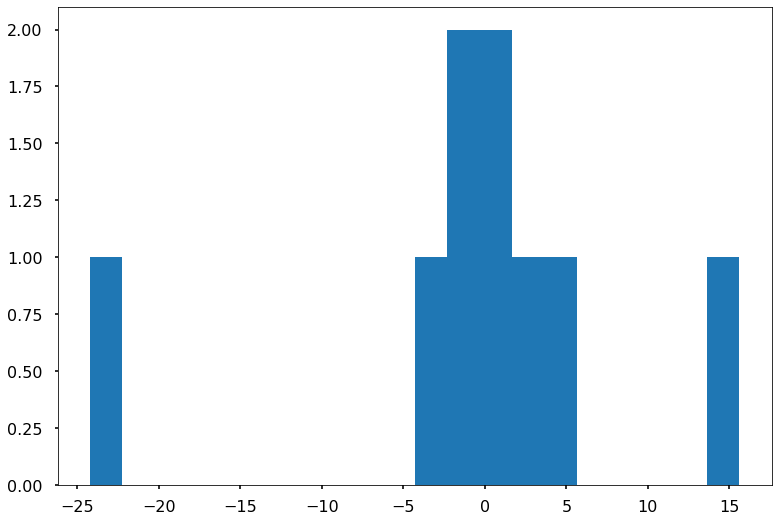

In [76]:
plt.hist(alert_time_diff_s_myshake_shakealert, bins=20)

In [ ]:
alert_time_diff_s_myshake_shakealert

In [71]:
df_matched_event['modtime']

0         1475002296
1         1475002296
2         1475002296
3         1475002296
4         1475002296
             ...    
195171    1602012155
195172    1602012155
195173    1602012155
195174    1602012155
195175    1602012155
Name: modtime, Length: 195176, dtype: int64